__Vi bygger en modell med XBOOST. Scora bara lopp med  E_P_num 1,2,3 och VNUM 1,2,3 i dessa lopp. Tre hästar i tre lopp med score. Lopp, häst E_P_NUM och score . Målvariabel de lopp där vinnaren finns i dessa lopp__

__Sorteringen ska visa svårighetsgraden på omgången. Ju högre svårighetsgrad desto mer hästar måste med. Vill skapa en score som sammanfattar loppet. Datat ligger på hästnivå, hästen springer i ett specifikt lopp__

__Ta bort VNUM, ODDS samt V75procent__

__Loppnivå - Vill rangordna alla hästar. Skala bort de hästar med minst sannolikhet att vinna__

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [4]:
df0 = pd.read_excel('AllData.xlsx')

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24585 entries, 0 to 24584
Data columns (total 36 columns):
Datum          24585 non-null datetime64[ns]
Arstid         24585 non-null int64
Distans        24585 non-null int64
Startsatt      24585 non-null int64
Lopp           24585 non-null int64
Plac           24585 non-null int64
Hast           24585 non-null int64
V75PROC        24585 non-null float64
V_ODDS         24585 non-null float64
GRUPP          24585 non-null int64
VLP            24585 non-null float64
VNUM           24585 non-null int64
SVLP           24585 non-null float64
VSVLP          24585 non-null float64
VPN_SUM        24585 non-null float64
VPN_SUM_ORD    24585 non-null int64
VPK_SUM        24585 non-null float64
VPK_SUM_ORD    24461 non-null float64
VLPB           24585 non-null float64
SVLPB          24585 non-null float64
VSVLPB         24585 non-null float64
E_P            24585 non-null float64
E_P_Num        24585 non-null int64
E_N            24585 non-null 

In [6]:
df0.Datum.max()

Timestamp('2019-12-28 00:00:00')

In [6]:
df0.E_P_Num.value_counts()

7    3812
6    3680
5    3590
4    3503
3    3435
2    3353
1    3212
Name: E_P_Num, dtype: int64

In [7]:
analys1 = df0[(df0.E_P_Num.isin([1,2,3])) & df0.Plac == 1].VNUM.value_counts()

In [8]:
len( df0[(df0.E_P_Num.isin([1,2,3])) & (df0.Plac == 1)])

904

In [9]:
(420 + 169 + 120) / 904

0.7842920353982301

In [10]:
analys1

1     420
2     169
3     120
4      67
6      38
5      32
8      19
7      18
9      13
10      6
14      1
11      1
Name: VNUM, dtype: int64

In [11]:
analys2 = df0[(df0.E_P_Num.isin([5,6,7])) & df0.Plac == 1].VNUM.value_counts()

In [12]:
len(df0[(df0.E_P_Num.isin([5,6,7])) & (df0.Plac == 1)])

905

In [13]:
(243 + 173 + 127) / 905

0.6

In [14]:
analys2

1     243
2     173
3     127
4      93
5      76
6      60
7      47
8      26
9      24
10     19
11      9
12      6
14      1
13      1
Name: VNUM, dtype: int64

In [15]:
(420 + 169 + 120) / 904

0.7842920353982301

In [16]:
df0.head()

,Datum,Arstid,Distans,Startsatt,Lopp,Plac,Hast,V75PROC,V_ODDS,GRUPP,...,G_R,A_R,T_R,SP_R,ToR,P_R,TK_R,Ex_R,R_R,Ts_R
0,2016-05-21,1,3,2,1,1,1,0.55,1.3,1,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1
1,2016-05-21,1,3,2,1,0,3,0.02,34.0,4,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0
2,2016-05-21,1,3,2,1,0,8,0.00,97.3,5,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0
3,2016-05-21,1,3,2,1,0,10,0.00,68.1,5,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0
4,2016-05-21,1,3,2,1,0,4,0.01,53.8,5,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0


In [17]:
df0.shape

(24585, 36)

In [18]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df0['cdate'] = df0.Datum.astype('object')
df0['cLopp'] = df0.Lopp.astype('object')

In [19]:
df0['Key'] = df0['cdate'].astype(str) + df0['cLopp'].astype(str)

__Skapar en målvariabel - vinnare__

In [20]:
# Alla analysvariabler
df1 = df0[df0.E_P_Num.isin([1,2,3])].set_index(['Key'])

# Rankingen samt VNUM. 
df1 = df1[['VNUM','G_R','A_R','T_R','SP_R','ToR','P_R','TK_R','R_R','Ts_R','Datum','Plac','Lopp']]    

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2016-05-21 00:00:001 to 2019-12-28 00:00:007
Data columns (total 13 columns):
VNUM     10000 non-null int64
G_R      9253 non-null float64
A_R      8660 non-null float64
T_R      9316 non-null float64
SP_R     7978 non-null float64
ToR      8835 non-null float64
P_R      9023 non-null float64
TK_R     6580 non-null float64
R_R      6704 non-null float64
Ts_R     10000 non-null int64
Datum    10000 non-null datetime64[ns]
Plac     10000 non-null int64
Lopp     10000 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 1.1+ MB


In [22]:
df1['Y'] = np.where((df1['Plac'].isin([1])) & (df1.VNUM.isin([1,2,3])),1,0)

In [23]:
df1.Y.value_counts()

0    9291
1     709
Name: Y, dtype: int64

In [24]:
df1[['Y','G_R','A_R','T_R','SP_R','ToR','P_R','TK_R','R_R','Ts_R']].corr()

,Y,G_R,A_R,T_R,SP_R,ToR,P_R,TK_R,R_R,Ts_R
Y,1.000000,0.176588,0.225937,0.210024,0.232435,0.167747,0.202571,0.198431,0.220742,0.228918
G_R,0.176588,1.000000,0.236117,0.250229,0.211057,0.193740,0.250722,0.240361,0.242910,0.247924
A_R,0.225937,0.236117,1.000000,0.406446,0.410905,0.302247,0.392828,0.302959,0.480443,0.408092
T_R,0.210024,0.250229,0.406446,1.000000,0.444110,0.315509,0.428237,0.312215,0.449749,0.432597
SP_R,0.232435,0.211057,0.410905,0.444110,1.000000,0.286709,0.397551,0.299334,0.468158,0.407937
ToR,0.167747,0.193740,0.302247,0.315509,0.286709,1.000000,0.290413,0.210025,0.294324,0.295947
P_R,0.202571,0.250722,0.392828,0.428237,0.397551,0.290413,1.000000,0.301926,0.407617,0.388395
TK_R,0.198431,0.240361,0.302959,0.312215,0.299334,0.210025,0.301926,1.000000,0.284613,0.304004
R_R,0.220742,0.242910,0.480443,0.449749,0.468158,0.294324,0.407617,0.284613,1.000000,0.421763
Ts_R,0.228918,0.247924,0.408092,0.432597,0.407937,0.295947,0.388395,0.304004,0.421763,1.000000


In [25]:
df2 = df1.copy(deep = True)

In [26]:
# Imputerar mode för median

miss_list = ['G_R','A_R','T_R','SP_R','ToR','P_R','TK_R','R_R','Ts_R']

for var in miss_list:
    df2[var] = df2[var].fillna(df2[var].median())


In [27]:
miss_list

['G_R', 'A_R', 'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'R_R', 'Ts_R']

In [28]:
df2[['Y','G_R','A_R','T_R','SP_R','ToR','P_R','TK_R','R_R','Ts_R']].corr()

,Y,G_R,A_R,T_R,SP_R,ToR,P_R,TK_R,R_R,Ts_R
Y,1.000000,0.167659,0.206988,0.200533,0.198055,0.152522,0.190909,0.152783,0.172045,0.228918
G_R,0.167659,1.000000,0.239119,0.262888,0.189876,0.200013,0.258245,0.203636,0.212278,0.261175
A_R,0.206988,0.239119,1.000000,0.397687,0.340306,0.287094,0.378094,0.240629,0.371855,0.400365
T_R,0.200533,0.262888,0.397687,1.000000,0.392648,0.315334,0.428107,0.260985,0.375203,0.442946
SP_R,0.198055,0.189876,0.340306,0.392648,1.000000,0.257076,0.340427,0.231988,0.366415,0.366918
ToR,0.152522,0.200013,0.287094,0.315334,0.257076,1.000000,0.284788,0.192285,0.265688,0.298366
P_R,0.190909,0.258245,0.378094,0.428107,0.340427,0.284788,1.000000,0.261414,0.329251,0.391492
TK_R,0.152783,0.203636,0.240629,0.260985,0.231988,0.192285,0.261414,1.000000,0.302305,0.255723
R_R,0.172045,0.212278,0.371855,0.375203,0.366415,0.265688,0.329251,0.302305,1.000000,0.354897
Ts_R,0.228918,0.261175,0.400365,0.442946,0.366918,0.298366,0.391492,0.255723,0.354897,1.000000


In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2016-05-21 00:00:001 to 2019-12-28 00:00:007
Data columns (total 14 columns):
VNUM     10000 non-null int64
G_R      10000 non-null float64
A_R      10000 non-null float64
T_R      10000 non-null float64
SP_R     10000 non-null float64
ToR      10000 non-null float64
P_R      10000 non-null float64
TK_R     10000 non-null float64
R_R      10000 non-null float64
Ts_R     10000 non-null int64
Datum    10000 non-null datetime64[ns]
Plac     10000 non-null int64
Lopp     10000 non-null int64
Y        10000 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 1.1+ MB


In [30]:
# Gör om till objekt

feat_list = ['G_R','A_R','T_R','SP_R','ToR','P_R','TK_R','R_R','Ts_R']

for var in feat_list:
    df2[var] = df2[var].astype('str')



In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2016-05-21 00:00:001 to 2019-12-28 00:00:007
Data columns (total 14 columns):
VNUM     10000 non-null int64
G_R      10000 non-null object
A_R      10000 non-null object
T_R      10000 non-null object
SP_R     10000 non-null object
ToR      10000 non-null object
P_R      10000 non-null object
TK_R     10000 non-null object
R_R      10000 non-null object
Ts_R     10000 non-null object
Datum    10000 non-null datetime64[ns]
Plac     10000 non-null int64
Lopp     10000 non-null int64
Y        10000 non-null int64
dtypes: datetime64[ns](1), int64(4), object(9)
memory usage: 1.1+ MB


In [114]:
# Egen klass för att sätta dummyvariabler

class SetDummyVar(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tempdf = pd.get_dummies(X[self.attribute_names], columns = self.attribute_names)
        return tempdf.values

In [115]:
df2.columns

Index(['VNUM', 'G_R', 'A_R', 'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'R_R',
       'Ts_R', 'Datum', 'Plac', 'Lopp', 'Y'],
      dtype='object')

In [116]:
df2.columns[:-4]

Index(['VNUM', 'G_R', 'A_R', 'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'R_R',
       'Ts_R'],
      dtype='object')

In [117]:
num_attribs = []
cat_attribs = []
for var, typ in zip(df2.columns[:-4], df2.dtypes[:-4]):
    if typ == 'object':
        cat_attribs.append(var)
    else:
        num_attribs.append(var) 

In [118]:
full_pipeline = Pipeline([
        ('dummy_cat', SetDummyVar(cat_attribs)),
    ])

In [119]:
cat_attribs

['G_R', 'A_R', 'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'R_R', 'Ts_R']

In [120]:
omg_df = pd.DataFrame({'Datum': list(set(df2.Datum.values.tolist()))})

In [121]:
# Next, Let's split the data into a training, validation, and testing.
rand_split = pd.DataFrame({'rval':np.random.rand(len(df2)).tolist()})

In [122]:
omg_df = pd.concat([omg_df,rand_split], axis = 1)
omg_df.head()

,Datum,rval
0,1.463789e+18,0.315909
1,1.464394e+18,0.001065
2,1.465603e+18,0.349968
3,1.464480e+18,0.909424
4,1.464998e+18,0.927011


In [123]:
omg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Datum    302 non-null float64
rval     10000 non-null float64
dtypes: float64(2)
memory usage: 156.3 KB


In [124]:
train_filter = (omg_df.rval <= 0.7)
test_filter = (omg_df.rval > 0.7) 

In [125]:
 # This dataset will be used to train the model.
train = df2[df2.Datum.isin(omg_df[train_filter]['Datum'].values.tolist())]

# This dataset will be used to test the model.

test = df2[df2.Datum.isin(omg_df[test_filter]['Datum'].values.tolist())]


In [126]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3006 entries, 2016-05-29 00:00:004 to 2019-12-26 00:00:005
Data columns (total 14 columns):
VNUM     3006 non-null int64
G_R      3006 non-null object
A_R      3006 non-null object
T_R      3006 non-null object
SP_R     3006 non-null object
ToR      3006 non-null object
P_R      3006 non-null object
TK_R     3006 non-null object
R_R      3006 non-null object
Ts_R     3006 non-null object
Datum    3006 non-null datetime64[ns]
Plac     3006 non-null int64
Lopp     3006 non-null int64
Y        3006 non-null int64
dtypes: datetime64[ns](1), int64(4), object(9)
memory usage: 352.3+ KB


__Bygger modellen - Logistik regression__

In [127]:
features_base = full_pipeline.fit_transform(train)
## En array som håller det vi vill predikter
label_base = train["Y"].copy()

In [128]:
features_test = full_pipeline.fit_transform(test)
## En array som håller det vi vill predikter
label_test = test["Y"].copy()

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [130]:
log_clf= LogisticRegression(solver="liblinear", C = 0.1, random_state=42)

# Utvärderar styrkan i modellen - sätter hyperparametrarna och cross fold fem
scores_base = cross_val_score(log_clf, features_base,label_base, scoring = "roc_auc", cv = 5 ) 

scores_base

array([0.89375   , 0.86635587, 0.87997669, 0.90460416, 0.89403659])

In [131]:
scores_base.mean()

0.887744662680575

## Validerar på undanlagt testdata

In [132]:
model_base = log_clf.fit(features_base,label_base)
log_clf.fit(features_base,label_base)
predict19 = log_clf.predict_proba(features_test)

fpr, tpr, threshold = roc_curve(label_test,predict19[:,1])
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.8757616711127248


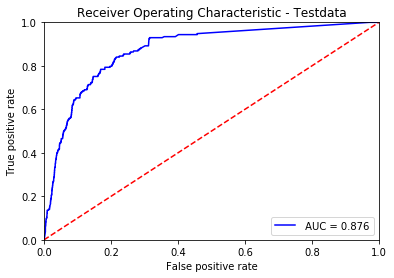

In [133]:
plt.title('Receiver Operating Characteristic - Testdata') 
plt.plot( fpr, tpr, 'b', label =' AUC = %0.3f' % roc_auc) 
plt.legend( loc ='lower right') 
plt.plot([ 0, 1], [0, 1], 'r--') 
plt.xlim([ 0.0, 1.0]) 
plt.ylim([ 0.0, 1.0]) 
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
plt.show()

__Sparar undan modellen i Pickleformat för att kunna användas i andra notebooks__

In [134]:
# from sklearn.externals import joblib

#import joblib

from sklearn.externals import joblib
from DataPipeline import DataFrameSelector



#Pipelineobjekt
joblib.dump(full_pipeline, 'Pipeline_vnum123.pkl')

# Modellobjekt
joblib.dump(model_base, 'Travmodel_vnum123.pkl')

['Travmodel_vnum123.pkl']

In [135]:
koll = joblib.load('Travmodel_vnum123.pkl')

In [136]:
type(koll)

sklearn.linear_model.logistic.LogisticRegression

In [137]:
koll1 = joblib.load('Pipeline_vnum123.pkl')

In [138]:
type(koll1)

sklearn.pipeline.Pipeline

In [112]:
full_pipeline = joblib.load('Pipeline_top1.pkl')